In [276]:
# Data Processing
import re
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

# NLP
from wordcloud import WordCloud

import spacy
nlp = spacy.load("es_core_news_sm")

# Others
import warnings
warnings.filterwarnings(action='ignore')

## Dataset

In [277]:
df = pd.read_csv('../data/raw/google_maps_all_reviews.csv')

In [278]:
print("Shape:", df.shape)

Shape: (3476, 8)


In [279]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3476 entries, 0 to 3475
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   place_id   3476 non-null   object 
 1   place_url  3476 non-null   object 
 2   review_id  3476 non-null   object 
 3   user_url   3476 non-null   object 
 4   username   0 non-null      float64
 5   stars      3476 non-null   int64  
 6   time       3474 non-null   object 
 7   text       3476 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 217.4+ KB


In [280]:
df.drop(columns=["place_url", "user_url", "username", "review_id"], inplace=True)

Estas columnas contienen metadatos como URLs o identificadores que no son necesarios para el análisis textual. No se toman en cuenta para reducir el volumen de datos y proteger la privacidad de los usuarios. En este caso, el estudio no tiene el objetivo de encontrar patrones de publicaciones entre usarios ni la identificacion de bots, sin embargo, se puede considerar mantenerlas.

In [281]:
df

,place_id,stars,time,text
0,club_majadas,5,Hace 3 meses,Costo beneficio correcto. Limpio y comodo de u...
1,club_majadas,5,Hace 5 años,Buena atención del personal. Muy higiénico. Ri...
2,club_majadas,5,Hace un año,Me encanto el lugar super recomendado La amabi...
3,club_majadas,5,Hace 8 años,"Un lugar para ejercitarse en el gimnasio, clas..."
4,club_majadas,5,Hace 3 años,"Un bello lugar para respirar aire puro, nadar,..."
...,...,...,...,...
3471,club_guatemala,5,Hace 7 años,Jose Miguel Montes Local Guide · 26 opiniones ...
3472,club_guatemala,3,Hace 8 años,Sandra Carmina Ventura Roldan       Hace...
3473,club_guatemala,4,Hace 8 años,Giovanni Ramirez Garcia Local Guide · 78 opini...
3474,club_guatemala,4,Hace 8 años,Sarita Arana       Hace 8 años


## Filtrado

In [282]:
def normalize_text(text):
    if not isinstance(text, str):
        try:
            import pandas as _pd
            if _pd.isna(text):
                text = ''
            else:
                text = str(text)
        except Exception:
            text = '' if text is None else str(text)

    text = text.lower()                         # Convert to lowercase
    text = re.sub(r'http\S+', '', text)         # Remove URLs
    text = re.sub(r'@\w+', '', text)            # Remove mentions
    text = re.sub(r'#\w+', '', text)            # Remove hashtags
    text = re.sub(r'\s+', ' ', text).strip()    # Remove extra whitespace
    
    convert_dict = {'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u', 'ü': 'u', 'ñ': 'ni'}
    for accented_char, normal_char in convert_dict.items():
        text = text.replace(accented_char, normal_char)

    return text

In [283]:
df["clean_text"] = df["text"].apply(normalize_text)

La normalización del texto:
- convertir a minúsculas
- eliminar URLs
- eliminar menciones
- eliminar hashtags
- eliminar espacios extra
- convertir acentos

Se hizo con el fin de reducir el ruido superficial y facilitar las tareas de tokenización, lematización y búsqueda. Sin embargo, se debe considerar que son reglas ad-hoc (como mapear "ñ" a "ni") lo que puede alterar palabras, nombres propios o borrar señales emocionales como emojis.

Por lo mismo, se considera importante conservar una columna text con el texto original para trazabilidad.

In [284]:
check_1 = pd.DataFrame()

check_1 = df[df['clean_text'].str.contains('·')]

print("Removing rows with '·' in text:", check_1.shape[0])
df = df.drop(check_1.index)
print("New shape:", df.shape)

Removing rows with '·' in text: 732
New shape: (2744, 5)


In [285]:
check_2 = pd.DataFrame()

re_expression = [r'hace \d+ anios', r'hace un anio', r'hace un mes', r'hace \d+ meses']

for expr in re_expression:
    temp = df[df['clean_text'].str.contains(expr)]
    check_2 = pd.concat([check_2, temp])
    print(f"Number of rows with '{expr}':", temp.shape[0])

print("\nRemoving", check_2.shape[0], "rows from df")
df = df.drop(index=check_2.index)
print("New shape:", df.shape)

Number of rows with 'hace \d+ anios': 515
Number of rows with 'hace un anio': 32
Number of rows with 'hace un mes': 2
Number of rows with 'hace \d+ meses': 13

Removing 562 rows from df
New shape: (2182, 5)


Se identificaron dos casos en especifico, por el formato malformateado que contienen ciertas reviews técnicamente antiguas que no tienen un valor de "text":
- Textos que contienen el símbolo ‘·’
- Frases como "hace 2 años", "hace un mes" 

Los valores de texto que contengan alguno de esos casos, se filtran. Sin embargo, para esto, se toman en cuenta dos supuestos:
- El símbolo ‘·’ no aparece legítimamente en reseñas ni en listas copiadas. 
- Las expresiones "hace 2 años", "hace un mes" no aparecen legítimamente en reseñas, se entiende que se realizan al corto plazo de haber visitado el lugar en cuestión.

In [286]:
df

,place_id,stars,time,text,clean_text
0,club_majadas,5,Hace 3 meses,Costo beneficio correcto. Limpio y comodo de u...,costo beneficio correcto. limpio y comodo de u...
1,club_majadas,5,Hace 5 años,Buena atención del personal. Muy higiénico. Ri...,buena atencion del personal. muy higienico. ri...
2,club_majadas,5,Hace un año,Me encanto el lugar super recomendado La amabi...,me encanto el lugar super recomendado la amabi...
3,club_majadas,5,Hace 8 años,"Un lugar para ejercitarse en el gimnasio, clas...","un lugar para ejercitarse en el gimnasio, clas..."
4,club_majadas,5,Hace 3 años,"Un bello lugar para respirar aire puro, nadar,...","un bello lugar para respirar aire puro, nadar,..."
...,...,...,...,...,...
3299,club_guatemala,5,Hace un año,Excelente,excelente
3303,club_guatemala,5,Hace 2 años,bantab,bantab
3305,club_guatemala,5,Hace 5 años,Desde,desde
3306,club_guatemala,5,Hace 7 años,Cicatrización,cicatrizacion


## Pre Procesamiento

### Valor "text"

In [287]:
def split_into_sentences(text):
    sentences = re.split(r'[.!?]+', text)
    
    cleaned_sentences = []
    for sentence in sentences:
        sentence = sentence.strip()
        sentence = re.sub(r'[^a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ\s]', '', sentence)
        if sentence and sentence != '':
            cleaned_sentences.append(sentence)
    
    return cleaned_sentences

In [288]:
df['sentences'] = df['clean_text'].apply(split_into_sentences)

Separar el texto en oraciones facilita tareas de lematización, extracción de entidades y análisis temático. Quitar caracteres no alfanuméricos puede reducir ruido, pero se acepta el riesgo de que se pueden llegar a eliminar emojis, puntuación enfática o símbolos que transmiten emociones.

In [289]:
df

,place_id,stars,time,text,clean_text,sentences
0,club_majadas,5,Hace 3 meses,Costo beneficio correcto. Limpio y comodo de u...,costo beneficio correcto. limpio y comodo de u...,"[costo beneficio correcto, limpio y comodo de ..."
1,club_majadas,5,Hace 5 años,Buena atención del personal. Muy higiénico. Ri...,buena atencion del personal. muy higienico. ri...,"[buena atencion del personal, muy higienico, r..."
2,club_majadas,5,Hace un año,Me encanto el lugar super recomendado La amabi...,me encanto el lugar super recomendado la amabi...,[me encanto el lugar super recomendado la amab...
3,club_majadas,5,Hace 8 años,"Un lugar para ejercitarse en el gimnasio, clas...","un lugar para ejercitarse en el gimnasio, clas...",[un lugar para ejercitarse en el gimnasio clas...
4,club_majadas,5,Hace 3 años,"Un bello lugar para respirar aire puro, nadar,...","un bello lugar para respirar aire puro, nadar,...",[un bello lugar para respirar aire puro nadar ...
...,...,...,...,...,...,...
3299,club_guatemala,5,Hace un año,Excelente,excelente,[excelente]
3303,club_guatemala,5,Hace 2 años,bantab,bantab,[bantab]
3305,club_guatemala,5,Hace 5 años,Desde,desde,[desde]
3306,club_guatemala,5,Hace 7 años,Cicatrización,cicatrizacion,[cicatrizacion]


In [290]:
def lemmatize_spacy(sentences):
    if isinstance(sentences, str):
        sentences = [sentences]
    if not isinstance(sentences, (list, tuple)):
        return []

    out = []
    for s in sentences:
        doc = nlp(s)
        lem = " ".join([token.lemma_ for token in doc if token.is_alpha])
        out.append(lem)
    return out

In [291]:
df['lemm_sentences'] = df['sentences'].apply(lemmatize_spacy)

Se aplica lematización para agrupar formas flexionadas de una palabra, lo que reduce la dimensionalidad del vocabulario y mejora la generalización en modelos. Sin embargo, los lematizadores pueden fallar en textos con jerga, errores ortográficos o dialectos, especialmente si el modelo no está bien ajustado al corpus.

In [292]:
nan_rows = df[df['lemm_sentences'].isna()]
nan_rows

,place_id,stars,time,text,clean_text,sentences,lemm_sentences


In [293]:
df = df.dropna(subset=['lemm_sentences'])
print("New shape:", df.shape)

New shape: (2182, 7)


### Valor "time"

In [294]:
current_year = datetime.datetime.now().year

In [295]:
def extract_year(time_str):
    if isinstance(time_str, str):
        time_str = time_str.lower().strip()
        time_str = time_str.replace("editado", "").strip()
        if "hace" in time_str:
            parts = time_str.split()
            if len(parts) == 3:
                try:
                    number = int(parts[1]) if parts[1].isdigit() else 1
                    unit = parts[2]
                    if "anio" in unit:
                        return current_year - number
                    elif "mes" in unit:
                        months_ago = number
                        year_adjustment = months_ago // 12
                        return current_year - year_adjustment
                    elif "semanas" in unit or "semana" in unit:
                        return current_year
                    elif "dias" in unit or "dia" in unit:
                        return current_year
                except ValueError:
                    return None
    return None

In [296]:
df["time"] = df["time"].apply(normalize_text)

In [297]:
df['real_time'] = df['time'].apply(extract_year)

La normalización y extracción del tiempo permite homogenizar formatos temporales, como eliminar la palabra "editado", y convertir frases relativas ("hace 2 años") en valores numéricos útiles para análisis temporal. Sin embargo, el método extract_year que asume patrones como "hace X" puede no cubrir formatos absolutos (fechas exactas) ni variaciones lingüísticas. 

In [298]:
nan_rows = df[df['real_time'].isna()]
nan_rows

,place_id,stars,time,text,clean_text,sentences,lemm_sentences,real_time
277,club_espaniol,4,,Excelente lugar amplio parqueo,excelente lugar amplio parqueo,[excelente lugar amplio parqueo],[excelente lugar amplio parqueo],NaN
319,club_espaniol,5,2 semanas atras,Excelente lugar,excelente lugar,[excelente lugar],[excelente lugar],NaN
1155,club_montania,5,,Un lugar muy bonito.,un lugar muy bonito.,[un lugar muy bonito],[uno lugar mucho bonito],NaN


In [299]:
df = df.dropna(subset=['real_time'])
print("New shape:", df.shape)

New shape: (2179, 8)


### Valor "stars"

In [300]:
df['real_stars'] = df['stars'] / 5.0

La normalización de la columna stars mediante facilita comparaciones entre datasets y el uso en modelos que esperan inputs en escala [0,1]. No obstante, se asume que no existen valores atípicos o escalas distintas a la conocida de 5 estrellas.

In [301]:
nan_rows = df[df['real_time'].isna()]
nan_rows

,place_id,stars,time,text,clean_text,sentences,lemm_sentences,real_time,real_stars


In [302]:
df = df.dropna(subset=['real_stars'])
print("New shape:", df.shape)

New shape: (2179, 9)


In [303]:
df = df.drop("stars", axis=1)

## Resumen

In [304]:
num_cols = df.select_dtypes(include=['number']).columns
print("\nNumerical columns:", list(num_cols))


Numerical columns: ['real_time', 'real_stars']


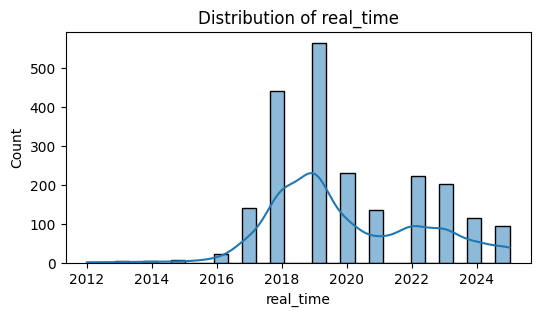

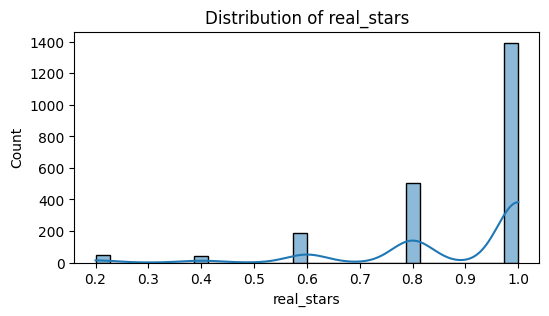

In [305]:
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

In [306]:
cat_cols = df.select_dtypes(include=['object', 'bool', 'category']).columns
print("\nCategorical columns:", list(cat_cols))


Categorical columns: ['place_id', 'time', 'text', 'clean_text', 'sentences', 'lemm_sentences']


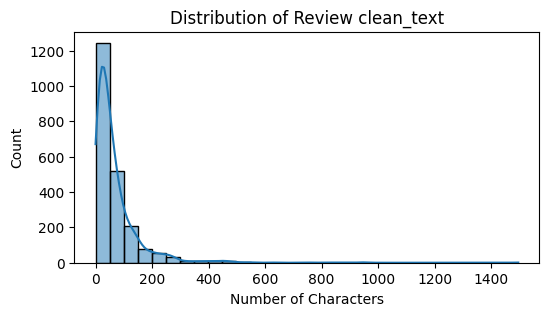

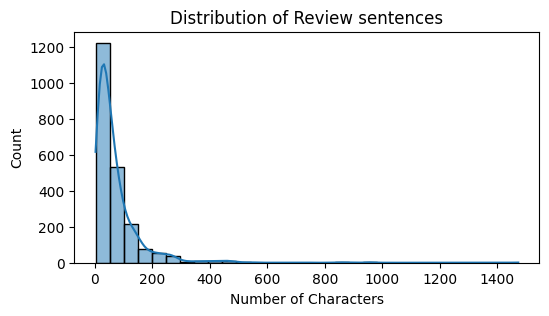

In [307]:
vals = ['clean_text', 'sentences']

for val in vals:
    df[val+'_length'] = df[val].astype(str).apply(len)
    plt.figure(figsize=(6, 3))
    sns.histplot(df[val+'_length'], bins=30, kde=True)
    plt.title('Distribution of Review '+val)
    plt.xlabel('Number of Characters')
    plt.show()

In [308]:
conteo = df["place_id"].value_counts().reset_index()
conteo.columns = ['place', 'count']

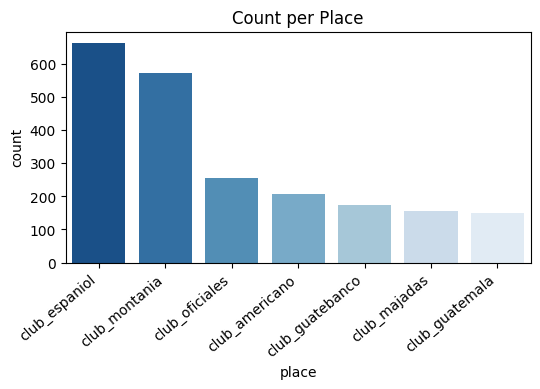

In [309]:
plt.figure(figsize=(6, 3))
colors = sns.color_palette("Blues", len(conteo)) [::-1]
ax = sns.barplot(data=conteo, x='place', y='count', palette=colors)
ax.set_ylabel('count')
ax.set_xlabel('place')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
ax.set_title('Count per Place')
plt.show()

## Guardado

In [310]:
new_df = df[['place_id', 'real_time', 'real_stars', 'sentences', 'lemm_sentences']].reset_index(drop=True)
new_df.rename(columns={'place_id': 'place', 'real_time': 'year', 'real_stars': 'stars'}, inplace=True)

In [311]:
new_df

,place,year,stars,sentences,lemm_sentences
0,club_majadas,2025.0,1.0,"[costo beneficio correcto, limpio y comodo de ...","[costo beneficio correcto, limpio y comodo de ..."
1,club_majadas,2020.0,1.0,"[buena atencion del personal, muy higienico, r...","[buen atencion del personal, mucho higienico, ..."
2,club_majadas,2024.0,1.0,[me encanto el lugar super recomendado la amab...,[yo encantar el lugar super recomendado el ama...
3,club_majadas,2017.0,1.0,[un lugar para ejercitarse en el gimnasio clas...,[uno lugar para ejercitar él en el gimnasio cl...
4,club_majadas,2022.0,1.0,[un bello lugar para respirar aire puro nadar ...,[uno bello lugar para respirar aire puro nadar...
...,...,...,...,...,...
2174,club_guatemala,2024.0,1.0,[excelente],[excelente]
2175,club_guatemala,2023.0,1.0,[bantab],[bantab]
2176,club_guatemala,2020.0,1.0,[desde],[desde]
2177,club_guatemala,2018.0,1.0,[cicatrizacion],[cicatrizacion]


In [312]:
new_df.to_csv('../data/processed/reviews.csv', index=False)